In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') 
import nltk

In [2]:
df=pd.read_csv('youtube_commentsTOMSCOT.csv')

In [3]:
df.head()

,Comment,Author,Likes
0,"Don&#39;t worry, I didn&#39;t travel to New Je...",Tom Scott,22337
1,Telling the audience that you&#39;re doing a t...,Anthony Harris,37983
2,It&#39;s amazing how Tom manages to look like ...,T2and3,8023
3,What I love is that he not only answers the qu...,Mara Jade,3941
4,I have an auditory processing disorder. I noti...,Dorian,3293


In [4]:
df['Id']=range(1,len(df)+1)

In [5]:
df.head()

,Comment,Author,Likes,Id
0,"Don&#39;t worry, I didn&#39;t travel to New Je...",Tom Scott,22337,1
1,Telling the audience that you&#39;re doing a t...,Anthony Harris,37983,2
2,It&#39;s amazing how Tom manages to look like ...,T2and3,8023,3
3,What I love is that he not only answers the qu...,Mara Jade,3941,4
4,I have an auditory processing disorder. I noti...,Dorian,3293,5


In [6]:
df.describe()

,Likes,Id
count,100.000000,100.000000
mean,1239.920000,50.500000
std,4612.232608,29.011492
min,0.000000,1.000000
25%,1.000000,25.750000
50%,4.000000,50.500000
75%,247.750000,75.250000
max,37983.000000,100.000000


In [7]:
example=df['Comment'][50]
print(example)

No matter how long or short your videos are, theu always seem to have most amount information as possible just so much so its keeps wanting for more, keep up the kick ass work Tom


Vader polarity scores test

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\R3i\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
sia=SentimentIntensityAnalyzer()

In [10]:

res={}
for i, row in tqdm(df.iterrows(),total=len(df)):
    text = row['Comment']
    my_id=row['Id']
    res[my_id]=sia.polarity_scores(text)

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
vader=pd.DataFrame(res).T
vader=vader.reset_index().rename(columns={'index':'Id'})
vader=vader.merge(df)



In [12]:
vader.head()

,Id,neg,neu,pos,compound,Comment,Author,Likes
0,1,0.118,0.850,0.032,-0.6850,"Don&#39;t worry, I didn&#39;t travel to New Je...",Tom Scott,22337
1,2,0.083,0.792,0.125,0.4939,Telling the audience that you&#39;re doing a t...,Anthony Harris,37983
2,3,0.000,0.751,0.249,0.7430,It&#39;s amazing how Tom manages to look like ...,T2and3,8023
3,4,0.000,0.845,0.155,0.4678,What I love is that he not only answers the qu...,Mara Jade,3941
4,5,0.112,0.830,0.058,-0.3415,I have an auditory processing disorder. I noti...,Dorian,3293


In [13]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [14]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained (MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

VADER vs ROBERTA


In [15]:
sia.polarity_scores(example)

{'neg': 0.147, 'neu': 0.825, 'pos': 0.028, 'compound': -0.6808}

In [16]:
example

'No matter how long or short your videos are, theu always seem to have most amount information as possible just so much so its keeps wanting for more, keep up the kick ass work Tom'

In [17]:
#Run for roberta

encoded_text=tokenizer(example,return_tensors='pt')
model(**encoded_text)
scores=model(**encoded_text)[0][0].detach().numpy()
scores=softmax(scores)
scores_dict={
    'roberta_neg':scores[0],
    'roberta_neu':scores[1],
    'roberta_pos':scores[2],
}
print(scores_dict)

{'roberta_neg': 0.005419907, 'roberta_neu': 0.07078101, 'roberta_pos': 0.92379904}


In [18]:
def polarity_scores_roberta(example):
    encoded_text=tokenizer(example,return_tensors='pt')
    model(**encoded_text)
    scores=model(**encoded_text)[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict={
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2],
    }
    return scores_dict

In [19]:
res={}
for i, row in tqdm(df.iterrows(),total=len(df)):
    try:
        text = row['Comment']
        my_id=row['Id']
        

        roberta_result=polarity_scores_roberta(text)
        res[my_id]=roberta_result
    except RuntimeError:
        print(f"Broke for id {my_id}")

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
results_df=pd.DataFrame(res).T
results_df=results_df.reset_index().rename(columns={'index':'Id'})
results_df=results_df.merge(df,how='left')

In [21]:
results_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos,Comment,Author,Likes
0,1,0.559226,0.345693,0.095082,"Don&#39;t worry, I didn&#39;t travel to New Je...",Tom Scott,22337
1,2,0.245185,0.587087,0.167728,Telling the audience that you&#39;re doing a t...,Anthony Harris,37983
2,3,0.013761,0.165677,0.820563,It&#39;s amazing how Tom manages to look like ...,T2and3,8023
3,4,0.017637,0.066208,0.916155,What I love is that he not only answers the qu...,Mara Jade,3941
4,5,0.214054,0.391593,0.394353,I have an auditory processing disorder. I noti...,Dorian,3293


In [22]:
def compare_columns(results_df):
    conditions = [
        (results_df['roberta_neg'] > results_df['roberta_neu']) & (results_df['roberta_neg'] > results_df['roberta_pos']),
        (results_df['roberta_neu'] > results_df['roberta_neg']) & (results_df['roberta_neu'] > results_df['roberta_pos']),
        (results_df['roberta_pos'] > results_df['roberta_neg']) & (results_df['roberta_pos'] > results_df['roberta_neu'])
    ]

    choices = ['Negative', 'Neutral', 'Positive']
    results_df['result'] = pd.Series(np.select(conditions, choices, default='Equal'), index=df.index)
    return results_df


In [23]:
results_df

,Id,roberta_neg,roberta_neu,roberta_pos,Comment,Author,Likes
0,1,0.559226,0.345693,0.095082,"Don&#39;t worry, I didn&#39;t travel to New Je...",Tom Scott,22337
1,2,0.245185,0.587087,0.167728,Telling the audience that you&#39;re doing a t...,Anthony Harris,37983
2,3,0.013761,0.165677,0.820563,It&#39;s amazing how Tom manages to look like ...,T2and3,8023
3,4,0.017637,0.066208,0.916155,What I love is that he not only answers the qu...,Mara Jade,3941
4,5,0.214054,0.391593,0.394353,I have an auditory processing disorder. I noti...,Dorian,3293
...,...,...,...,...,...,...,...
95,96,0.001679,0.011936,0.986384,I love that he says &#39;its okay! You can tru...,Sporkle BlueMoon,1
96,97,0.006576,0.059833,0.933590,I love how he just answers the question right ...,Lucas Tomasi Enderle,274
97,98,0.011024,0.154258,0.834718,"tom is the type of person who, despite not hav...",Xcyiterr,0
98,99,0.003850,0.021572,0.974578,Your videos are a land of answers to questions...,FitBigSexy123,0


In [24]:
result_data = compare_columns(results_df)


In [25]:
result_data

,Id,roberta_neg,roberta_neu,roberta_pos,Comment,Author,Likes,result
0,1,0.559226,0.345693,0.095082,"Don&#39;t worry, I didn&#39;t travel to New Je...",Tom Scott,22337,Negative
1,2,0.245185,0.587087,0.167728,Telling the audience that you&#39;re doing a t...,Anthony Harris,37983,Neutral
2,3,0.013761,0.165677,0.820563,It&#39;s amazing how Tom manages to look like ...,T2and3,8023,Positive
3,4,0.017637,0.066208,0.916155,What I love is that he not only answers the qu...,Mara Jade,3941,Positive
4,5,0.214054,0.391593,0.394353,I have an auditory processing disorder. I noti...,Dorian,3293,Positive
...,...,...,...,...,...,...,...,...
95,96,0.001679,0.011936,0.986384,I love that he says &#39;its okay! You can tru...,Sporkle BlueMoon,1,Positive
96,97,0.006576,0.059833,0.933590,I love how he just answers the question right ...,Lucas Tomasi Enderle,274,Positive
97,98,0.011024,0.154258,0.834718,"tom is the type of person who, despite not hav...",Xcyiterr,0,Positive
98,99,0.003850,0.021572,0.974578,Your videos are a land of answers to questions...,FitBigSexy123,0,Positive


<AxesSubplot: xlabel='result', ylabel='count'>

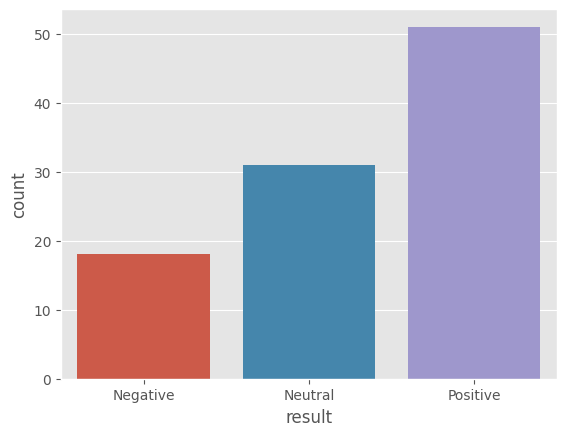

In [26]:
sns.countplot(x='result',data=result_data)

In [37]:
import plotly.express as px
df = px.data.tips()
fig = px.box(result_data, x="result", y="Likes")
fig.show()